<h1><center>Laboratorio 7: La desperación de Mr. Lepin 🐼</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla, Ignacio Meza
- Auxiliar: Sebastián Tinoco
- Ayudante: Felipe Arias, Diego Cortez

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Canela Orellana
- Nombre de alumno 2: Isabel Marx


### **Link de repositorio de GitHub:** https://github.com/CanelaOrellana/MDS7202-IsabelMarx-y-CanelaOrellana

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

# Temas a tratar

- Aplicar Pandas para obtener características de un DataFrame.
- Aplicar Pipelines.
- Aplicar Clusters sobre un conjunto de datos.

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio

- Comprender y aprovechar las ventajas que nos ofrece la librería `pandas` con respecto a trabajar en Python 'puro'.
- Crear nuevas características para entrenar un modelo de clustering.
- Comprender como aplicar pipelines de Scikit-Learn para generar procesos más limpios.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `numpy`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre arreglos (*o tensores*).

## Descripción del laboratorio.

### Importamos librerias utiles 😸

In [49]:
# Libreria Core del lab.
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import datetime
from IPython.display import HTML

# Libreria para plotear (En colab esta desactualizado plotly)
!pip install --upgrade plotly
import plotly.express as px
import plotly.graph_objects as go

# Librerias utiles
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = '/content/drive/MyDrive/online_retail_II_cleaned.pickle'
except: 
    print('Ignorando conexión drive-colab')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Segmentación de Clientes en Tienda de Retail 🛍️

<p align="center">
  <img width=300 src="https://s1.eestatic.com/2018/04/14/social/la_jungla_-_social_299733421_73842361_854x640.jpg">
</p>

## 1.1 Cargar Dataset

Mr. Lepin, en una nueva reunión, le cuenta a ud y su equipo que los resultados derivados del análisis exploratorio de dato presentaron una gran utilidad para la empresa y que tiene un gran entusiasmo por continuar trabajando con ustedes.
Es por esto, que Mr. Lepin les pide que cargue y visualicen algunas de las filas que componen el Dataset.
A continuación un extracto de lo parlamentado en la reunión:

    - Usted: Es un gran logro para nuestro equipo que usted haya encontrado excelente el EDA. ¿Qué tiene en mente ahora?
    - Mr. Lepin: Resulta que hace algún tiempo, mientras tomaba un mojito en una reunión de gerentes en Panamá, oí a un *chato* acerca de **LRMFP**, que es un modelo que permite personificar a los clientes a través de la fabricación de distintos atributos que describen a los clientes. Lo encontré es-tu-pendo ñatito. 
    - Usted: Ehh bueno. Investigaremos acerca de este modelo y veremos lo que podemos hacer.

Por ende, su siguiente tarea es calcular **LRMFP** sobre cada cliente y luego hacer un análisis de las características generadas. Para esto, el área de ventas les entrega un nuevo archivo llamado `online_retail_II_cleaned.pickle`, quien posee los datos del DataFrame original limpios y listos para obtener las características solicitadas por Mr. Lepin.

In [51]:
df_retail = pd.read_pickle(path)
df_retail = df_retail.astype(
    {
        "Invoice": "category",
        "StockCode": "category",
        "Description": "category",
        "Description": str,
        "Customer ID": "category",
        "Country": "category"
    }
)
df_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 1.2 Creación de nuevas Caracteristicas [2 Puntos] 

Como ya se les comento, Mr. Lepin esta interesado en obtener las características **LRMFP**, para esto les señala que estas características se construyen en base a las siguientes definiciones:

- **Length (L)**: Intervalo de tiempo, en días, entre la primera y la última visita del cliente. Mientras mas grande sea el valor, mas fiel es el cliente.

- **Recency (R)**: Indica hace cuanto tiempo el cliente realizo su ultima compra. Notar que para este caso, mientras mas grande es el valor, menos interes posee el usuario para repetir una compra en uno de los locales.

- **Monetary (M)**: El término "monetario" se refiere a la cantidad media de dinero gastada por cada visita del cliente durante el período de observación y refleja la contribución del cliente a los ingresos de la empresa.

- **Frequency (F)**: Se refiere al número total de visitas del cliente durante el periodo de observación. Cuanto mayor sea la frecuencia, mayor será la fidelidad del cliente. 

- **Periodicity (P)**: Representa si los clientes visitan las tiendas con regularidad.

$$Periodicity(n)=std(IVT_1, ..., IVT_n)$$

&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Donde $IVT$ denota el tiempo entre visitas y n representa el número de valores de tiempo entre visitas de un cliente.
 

$$IVT_i=date\_diff(t_{i+1},t)$$

En base a las definiciones señaladas, diseñe una función que permita obtener las características **LRMFP** recibiendo un DataFrame como entrada. Para esto, no estará permitido el uso de iteradores, utilice todas las herramientas que les ofrece `pandas` para realizar esto.

Una referencia que le puede ser útil es el [documento original](https://www.researchgate.net/publication/315979555_LRFMP_model_for_customer_segmentation_in_the_grocery_retail_industry_a_case_study) en donde se propone este método.

**Ejemplo de Resultado Esperado:**

| Customer ID | Length | Recency | Frequency | Monetary | Periodicity |
|------------:|-------:|--------:|----------:|---------:|------------:|
|   12346.0   |    294 |      67 |        46 |   -64.68 |        37.0 |
|   12347.0   |     37 |       3 |        71 |  1323.32 |         0.0 |
|   12349.0   |    327 |      43 |       107 |  2646.99 |        78.0 |
|   12352.0   |     16 |      11 |        18 |   343.80 |         0.0 |
|   12356.0   |     44 |      16 |        84 |  3562.25 |        12.0 |

**Respuesta:**

In [52]:
def custom_features(dataframe_in):
    dataframe_in.sort_values(['Customer ID','InvoiceDate'], inplace=True)
    L = dataframe_in[['Customer ID','InvoiceDate']].groupby('Customer ID').max()-dataframe_in[['Customer ID','InvoiceDate']].groupby('Customer ID').min()
    L = L['InvoiceDate']
    L = L.apply(lambda x: (x.days))
    R = df_retail[['InvoiceDate']].max().add(pd.Timedelta(days=1)).sub(df_retail[['Customer ID','InvoiceDate']].groupby('Customer ID').max())
    R = R['InvoiceDate']
    R = R.apply(lambda x: (x.days))
    M = dataframe_in[['Customer ID','Price']].groupby('Customer ID').mean()
    M = M['Price']
    F = dataframe_in[['Customer ID','Invoice']].groupby('Customer ID').nunique()
    p1 = dataframe_in[['Customer ID','Invoice']].reset_index().groupby(['Invoice']).last().sort_values('Customer ID')
    p1_index = p1['index']
    p1.sort_values(['Customer ID','Invoice'])
    p2 = df_retail.loc[p1_index,:].sort_values(['Customer ID','InvoiceDate'])
    p3 = p2[['Customer ID','InvoiceDate']].groupby(['Customer ID']).diff()
    p3['Invoice'] = p2['Invoice']
    p3['InvoiceDateDiff'] = p3['InvoiceDate']
    p3['InvoiceDate'] = p2['InvoiceDate']
    p3['Customer ID'] = p2['Customer ID']
    p4 = p3.sort_values(['Customer ID','InvoiceDate'])
    p5 = p4[['Customer ID','InvoiceDateDiff']][p4['InvoiceDateDiff'].notnull()]
    days = p5['InvoiceDateDiff'].apply(lambda x: (x.days))
    p5['Days'] = days
    p5.sort_values(['Customer ID'], inplace=True)
    p5 = p5.groupby('Customer ID').std().fillna(0)
    dataframe_out = L.reset_index()
    dataframe_out.rename(columns={"InvoiceDate": "Length"}, inplace=True)
    R = R.reset_index()[['InvoiceDate']]
    dataframe_out['Recency'] = R
    M = M.reset_index()[['Price']].round(2)
    dataframe_out['Monetary'] = M
    F = F.reset_index()[['Invoice']]
    dataframe_out['Frequency'] = F
    dataframe_out['Periodicity'] = p5.reset_index()['Days'].round(1)
    return(dataframe_out.set_index('Customer ID'))

In [53]:
custom_features(df_retail)

<ipython-input-52-e089c160b776>:26: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Length,Recency,Monetary,Frequency,Periodicity
Customer ID,,,,,
12346.0,196,165,6.25,11,36.7
12347.0,37,3,2.30,2,0.0
12348.0,0,74,0.72,1,0.0
12349.0,181,43,8.58,3,101.8
12351.0,0,11,2.36,1,0.0
...,...,...,...,...,...
18283.0,275,18,2.20,6,61.8
18284.0,0,67,3.25,1,0.0
18285.0,0,296,8.35,1,0.0


**Resúesta de Pauta:**

## 1.3 Pipelines 👷

Finalmente *Don Mora* le pregunta si seria posible realizar un pipeline para realizar una segmentación de los clientes con los nuevos datos generados, a lo que usted responde que **sí** y propone la utilización de k-means para la segmentación.

A continuación siga los pasos requeridos para obtener la segmentación de clientes.

### 1.3.1 Estandarizar Caracteristicas [0.5 puntos]

Construya una clase llamada ``MinMax()`` utilizando ``BaseEstimator`` y ``TransformerMixin`` para realizar una transformación de cada una de las columnas de un DataFrame utilizando ``ColumnTransformer()`` más tarde (tome como referencia el siguiente [enlace](https://sklearn-template.readthedocs.io/en/latest/user_guide.html#transformer)).


 Para esto considere que Min-Max escaler queda dada por la ecuación:

$$MinMax = \dfrac{x-min(x)}{max(x) - min(x)}$$

Con esto buscamos que los valores que componen a las columnas se muevan en el rango de valores $[0, 1]$.

**Respuesta:**

In [54]:
class MinMax(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.concat([X.min().to_frame().T,X]).diff().iloc[1:].div(pd.concat([X.min().to_frame().T,X.max().to_frame().T]).diff().iloc[1], axis='columns')

### 1.3.2 `T-SNE` Pipeline [1.0 puntos]

Para comenzar introduciéndose en el uso de pipeline, decide probar realizando un pipeline enfocado en la reducción de dimensionalidad y así hacer no decepcionar a Mr. Lepin con la clusterización del modelo. 

Configure un pipeline utilizando el algoritmo `T-SNE` sobre los datos **LRMFP**, donde, para la realización del pipeline considera los siguientes pasos:

1. Como primer paso obtenga las características **LRMFP** desde el DataFrame ``df_retail_II_cleaned.pickle`` utilizando la función ``custom_features`` creada anteriormente, junto a ``FunctionTransformer()``. Considere esto como el primer paso de su pipeline.
2. En segundo lugar usando ``ColumnTransformer()`` aplique el MinxMax scaler creado por usted sobre todas las columnas generadas en el paso anterior. 
3. Finalmente, aplique un último paso donde obtiene las 2 componentes más relevantes utilizando el algoritmo `T-SNE` de sckit-learn.

Tras aplicar las transformaciones sobre el dataset **LRMFP**, gráfique las componentes obtenidas en la reducción de dimensionalidad.

**Respuesta:**

In [55]:
ft = FunctionTransformer(custom_features)
ct = ColumnTransformer(
    [("MinMax", MinMax(), ["Length", "Recency", "Monetary", "Frequency", "Periodicity"])], remainder="passthrough"
    )
tsne = TSNE(n_components = 2)

pipe = Pipeline([("FunctionTransfomrer", ft),("ColumnTransformer", ct),("t-SNE", tsne)])

#features_to_scale = LRMFP#.iloc[:, :-2]

#LRMFP = pipe.fit(df_retail)[]
tsne_features = pipe.fit_transform(df_retail)

<ipython-input-52-e089c160b776>:26: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<ipython-input-52-e089c160b776>:26: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<Axes: xlabel='x', ylabel='y'>

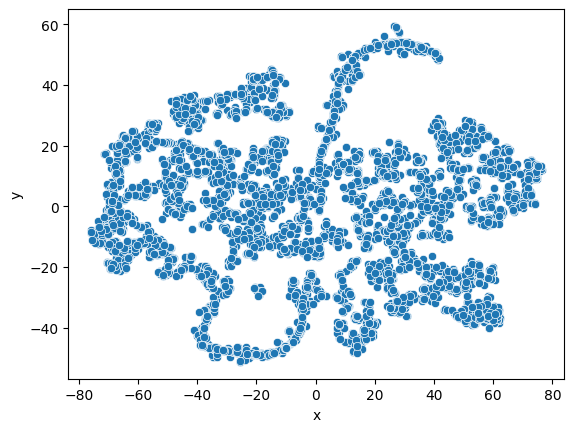

In [56]:
LRMFP = custom_features(df_retail)
LRMFP['x'] = tsne_features[:,0]
LRMFP['y'] = tsne_features[:,1]
sns.scatterplot(x='x',y='y',data=LRMFP)

<Axes: xlabel='x', ylabel='y'>

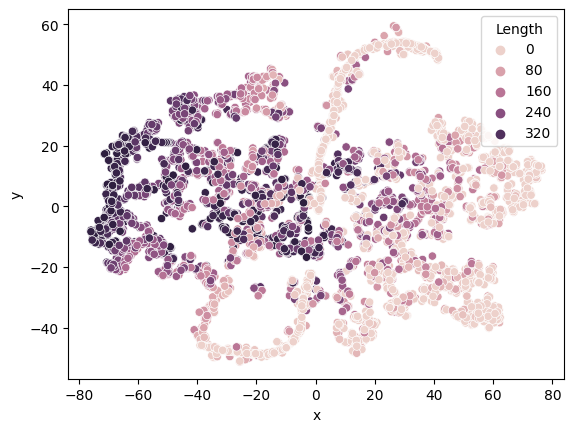

In [57]:
LRMFP['x'] = tsne_features[:,0]
LRMFP['y'] = tsne_features[:,1]
sns.scatterplot(x='x',y='y',hue='Length',data=LRMFP)

<Axes: xlabel='x', ylabel='y'>

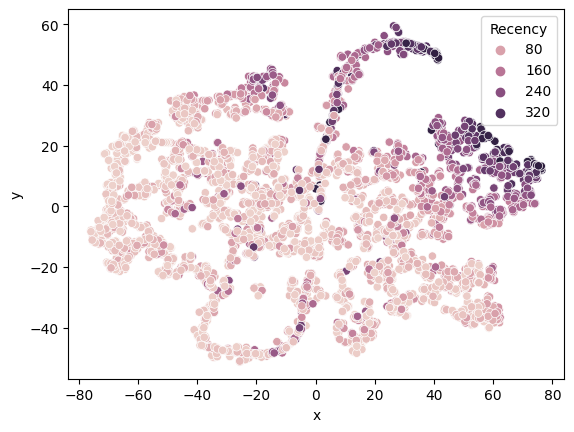

In [58]:
LRMFP['x'] = tsne_features[:,0]
LRMFP['y'] = tsne_features[:,1]
sns.scatterplot(x='x',y='y',hue='Recency',data=LRMFP)

<Axes: xlabel='x', ylabel='y'>

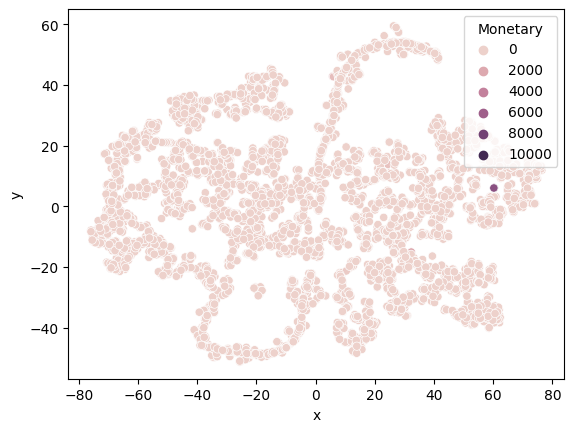

In [59]:
LRMFP['x'] = tsne_features[:,0]
LRMFP['y'] = tsne_features[:,1]
sns.scatterplot(x='x',y='y',hue='Monetary',data=LRMFP)

<Axes: xlabel='x', ylabel='y'>

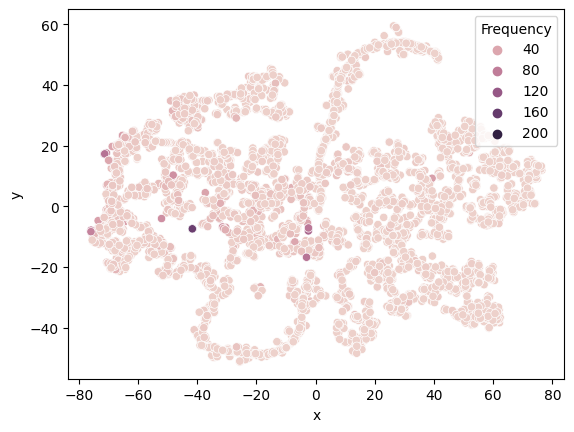

In [60]:
LRMFP['x'] = tsne_features[:,0]
LRMFP['y'] = tsne_features[:,1]
sns.scatterplot(x='x',y='y',hue='Frequency',data=LRMFP)

<Axes: xlabel='x', ylabel='y'>

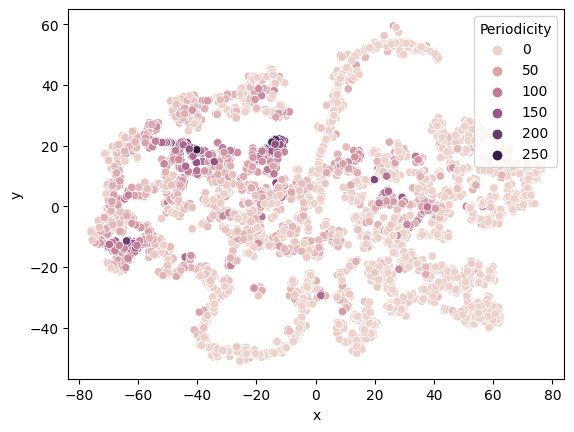

In [61]:
LRMFP['x'] = tsne_features[:,0]
LRMFP['y'] = tsne_features[:,1]
sns.scatterplot(x='x',y='y',hue='Periodicity',data=LRMFP)

### 1.3.3 Clustering

#### 1.3.3.1 Método del Codo [1 puntos]

Utilizando la clase creada para escalamiento, aplique el método del codo para visualizar cual es el número de clusters que mejor se ajustan a los datos. Realice esto utilizando el algoritmo K-means dentro de un pipeline para un $k \in [1,20]$, donde k representa el número de clusters del k-means. Para la realización de esta sección y la próxima (1.3.3.2), considere los mismos pasos utilizados para el t-sne, pero **permutando el algoritmo de reducción de dimensionalidad por k-means.**

A través del grafico obtenido, comente y justifique que valor de k escogería para realizar el k-means.

**Respuesta:**

In [63]:
km = KMeans(random_state=1)
pipeline = Pipeline([("FunctionTransfomrer", ft), ("ColumnTransformer", ct), ("KMeans", km)])
clear_output()

In [64]:
fit_inertias = [
    [i, pipeline.set_params(KMeans__n_clusters=i).fit(df_retail)["KMeans"].inertia_]
    for i in range(1,21)
]
sec = pd.DataFrame(fit_inertias, columns=["n° clusters", "inertia"])
clear_output()

In [65]:
px.line(
    sec,
    x="n° clusters",
    y="inertia",
    title="Método del Codo con K-Means",
    height=600,
)

En la figura anterior se observan los números de clusters vs la suma de errores cuadrados de cada modelo. El número de clusters en el que "el codo se dobla", se considera el punto óptimo donde el número de clusters es mínimo y también lo es la suma de errores cuadrados. Luego, se elige un número de clusters $k = 3$.

#### 1.3.3.2 Segmentación de Clientes con K-Means 🎁 [1 punto]

En base a la elección de k realizada en la sección anterior, utilice este valor escogido y entrene un modelo de K-means utilizando el mismo pipeline de scikit-learn utilizado anteriormente.

Una vez ajustado los datos, genere una tabla con los promedios (o medianas) para cada uno de los atributos, agrupando estos por el clúster que pertenecen. ¿Es posible observar agrupaciones coherentes?, ¿Qué tipo de clientes posee el retail?, Justifique su respuesta y no decepcione a Mr. Lepin.


**Respuesta:**

In [66]:
pipeline.set_params(KMeans__n_clusters=3)
pipeline.fit(df_retail)
cluster = pd.DataFrame(pipeline.predict(df_retail))
clear_output()

In [77]:
LRMFP["Cluster"] = cluster[0].to_list()
LRMFP.groupby("Cluster").mean().round(1)

,Length,Recency,Monetary,Frequency,Periodicity,x,y
Cluster,,,,,,,
0,33.9,141.0,23.9,1.9,5.1,49.400002,-7.0
1,247.2,36.8,3.7,7.6,38.2,-48.599998,-0.4
2,117.3,98.3,6.0,3.9,18.7,3.000000,3.3


**Respuesta Esperada:**

|         | Length  | Recency   | Frequency | Monetary | Periodicity |       |
|---------|---------|-----------|----------|-------------|-------|-------|
| Cluster |         |           |          |             |       |       |
|    0    |   258.8 |      45.2 |     76.1 |      1107.7 | 107.6 |   449 |
|    1    |    76.1 |     217.6 |     45.5 |       791.7 |  14.1 |   466 |
|    2    |   368.5 |       4.8 |   2715.0 |    226621.6 |   4.2 |     4 |
|    3    |    85.3 |      45.7 |     65.8 |      1047.0 |  10.5 |   987 |
|    4    |   347.2 |      15.9 |   1658.0 |     35829.3 |   8.0 |    25 |
|    5    |   298.0 |      29.8 |    183.8 |      3639.9 |  32.0 |  1188 |

Es posible observar agrupaciones coherentes, a partir de ellas se puede decir que el retail de Mr Lepin tiene 3 tipos de clientes:

El cluster 0 identifica a aquellos clientes que usualmente no concurren a esta tienda de retail, ya que su frecuencia en promedio es de 1,9 esto nos dice que gran pate de los que pertenecen al grupo sólo ha comprado en la tienda una vez. Por otra parte se observa que en promedio son aquellos que hace más tiempo dejaron de ir a la tienda y sus visitas se distanciaron en promedio aproximadamente un mes. Lo más llamtivo de este cluster es que son aquellos que en promedio más gastan en el retail. Así, se podría pensar que este grupo de clientes corresponde a gente que no vive ni transita cerca del retail y fue específicamente a realizar una compra, probablemente grande, como un electrodoméstico o muebles.

El cluster 1 identifica a los clientes más antiguos del retail (en base a Length), son aquellos cuya última visita en promedio fue hace un mes, es decir, es relativamente reciente. La mayoría de ellos ha comprado en promedio 8 veces y por lo general no gastan sumas muy elevadas en el retail. Se podría pensar que son personas que pasan usualmente por fuera del retail y de vez en cuando entran y llevan algo pequeño, un engañito o para aprovechar alguna oferta.

Finalmente el cluster 2 identifica un segmento de clientes que está en un punto medio entre los dos anteriores, tienen mayor antiguedad como clientes que los del cluster 0, pero menor que los del cluster 1. La última compra que realizaron fue en promedio hace 3 meses y la mayoría de ellos ha comprado 4 veces en el retail. Por otra parte han gastado sumas mayores de dinero que los del cluster 1, pero tampoco tan elevadas como las del cluster 0. Se podría pensar que este cluster corresponde a familias o personas que van acompañadas, no tan seguido, por ejemplo un fin de semana al mes y compran cosas para más de uno,lo cual explicaría los valores promedio observados.

Esperamos no decepcionar a Mr Lepin, ya que como él predijo, con esta técnica de LRMFP logramos caracterizar a cada tipo de cliente y esto le permitirá a el tomar nuevas estrategias de marketing y negocio enfocadas en cada tipo de cliente que posee, de manera más personalizada.

#### 1.3.3.3 Plot de K-Means 📈 [0.5 puntos]



Por último, Mr. Lepin, impaciente de no entender lo que usted intenta explicarle, le solicita que por favor muestre algún resultado "visual" de los grupos encontrados.

Para esto, grafique nuevamente las características encontradas usando `T-SNE` (no calcule de nuevo, simplemente utilice las proyecciones encontradas) y agregue las labels calculadas con kmeans como el argumento `color`.   

Comente: ¿Se separan bien los distintos clusters en la visualización?


**Respuesta:**

<Axes: xlabel='x', ylabel='y'>

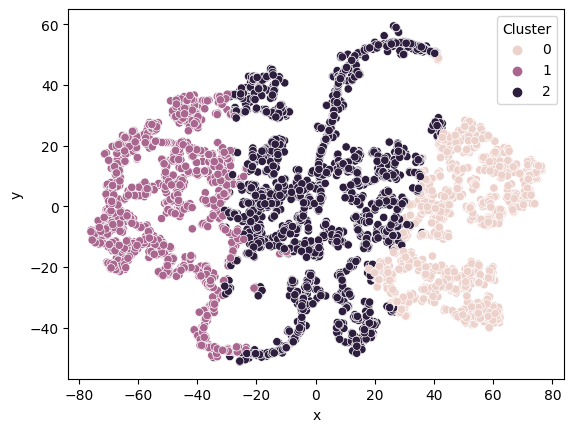

In [73]:
LRMFP['x'] = tsne_features[:,0]
LRMFP['y'] = tsne_features[:,1]
sns.scatterplot(x='x',y='y',hue='Cluster',data=LRMFP)

Si bien los clusters presentan una clara distinción entre ellos, se pueden notar algunas muestras *outliers* que difieren de su cluster asignado.

Si bien se observan algunas muestras anómalas, el resultado obtenido a simple vista tiene bastante precisión. Incluso se podría separar el espacio de las componentes más relevantes con hiperplanos para delimitar los *clusters*. Luego, Mr. Lepin debería estar muy contento con el estupendo modelo obtenido.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por correo, Discord o U-cursos.

![Gracias Totales!](https://i.pinimg.com/originals/65/ae/27/65ae270df87c3c4adcea997e48f60852.gif "bruno")


<br>
<center>
<img src="https://i.kym-cdn.com/photos/images/original/001/194/195/b18.png" width=100 height=50 />
</center>
<br>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>